In [1]:
import numpy as np
import time
from IPython.display import Image
from astropy.io import fits
from astropy import wcs
from astropy import units as u
from astropy.time import Time
from astropy.io import ascii
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
import astropy.coordinates as coord
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from matplotlib.colors import LogNorm
from astropy.visualization import hist
from IPython.display import clear_output
from astropy.utils.data import get_pkg_data_filename
from alpaca import Telescope, Camera, FilterWheel
from ciboulette.base import ciboulettepy as Cbl
import os

In [2]:
# Initialisation Ciboulette
cbl = Cbl.Ciboulette()

# Changement de focale
cbl.focale = 85.0

# Initialisation Telescope
# Changement de device pour le telescope simulator
telescope = Telescope(cbl.server, cbl.device)

# Initialisation FilterWheel
# Changement de device pour le filterwheel remise en l'état
filterwheel = FilterWheel(cbl.server, cbl.device)

# Initialisation FilterWheel
# Changement de device pour le ccd remise en l'état
ccd = Camera(cbl.server, cbl.device)

In [3]:
objectname = 'SECTOR1' # Pas d'espace
exptime = '1' # En seconde
inc_DEC_deg = -7 # Incrément de déplacement de la monture en DEC
inc_RA_deg = 0.0000 # Incrément de déplacement de la monture en RA
frame = [1,2,3,4,5] 
fitsname = 'C1_' # Répertoire de stockage
black_dataset = '/home/dataset/noir' # Répertoire de stockage noir
index = 0

# Changement de l'objet
cbl.object_name = objectname

filterwheel.position(1)

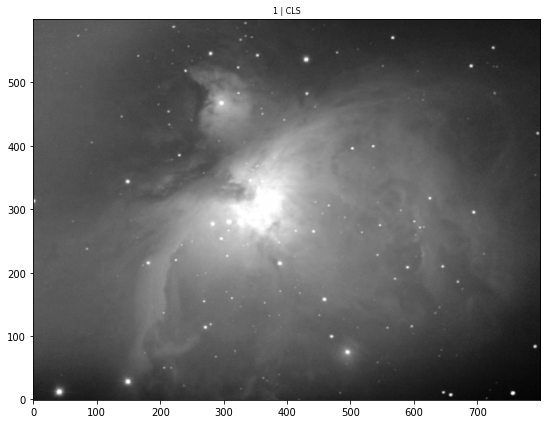

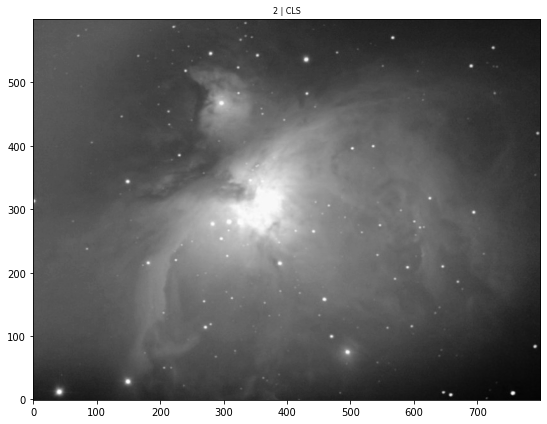

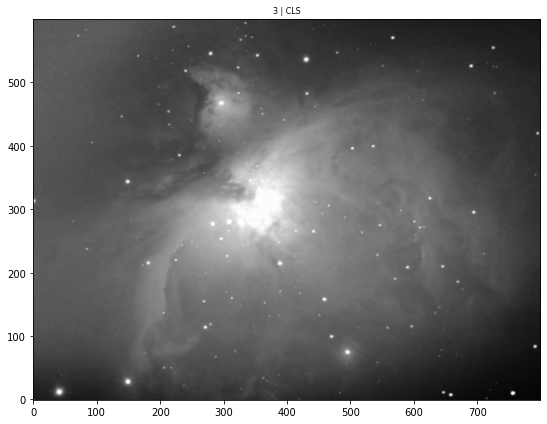

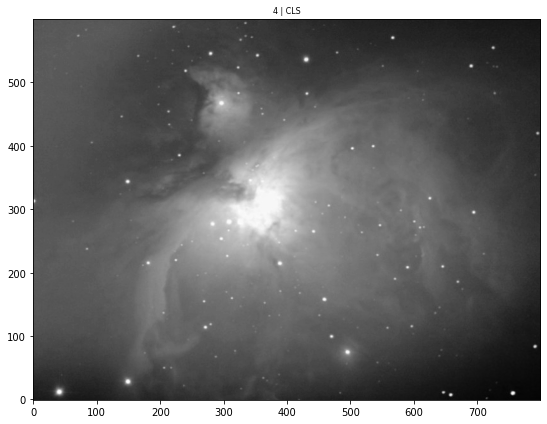

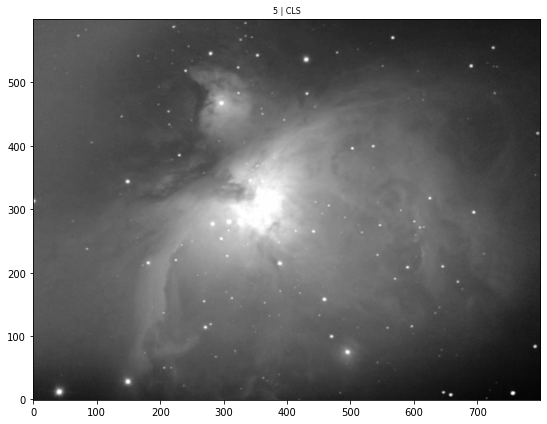

In [4]:
# Indi Client

for frameid in frame :
         
    # Shoot
    ccd.startexposure(exptime,True)

    while not ccd.imageready():
        time.sleep(1)
         
    date_obs = ccd.lastexposurestarttime()
    binx = ccd.binx()
    biny = ccd.biny()
    sizex = ccd.pixelsizex()
    sizey = ccd.pixelsizey()
    camxsize = ccd.cameraxsize()
    camysize = ccd.cameraysize()   
    ccd_temperature = ccd.ccdtemperature()

    # Lecture de l'image
    data_ccd = ccd.imagearray()
    data_new = np.rot90(data_ccd)
    data_int16 = data_new.astype(np.int16) 
    #data_real = np.fliplr(data_int16) # inversion verticale  
    
    # Initialisation des données
    object_name = cbl.object_name
    telescope_name = cbl.telescope_name
    instrument_name = cbl.instrument
    observer_name = cbl.observer_name
    focale = cbl.focale
    observer_name = cbl.observer_name
    dataset = cbl.dataset
    driver_name = cbl.driver_name
    
    RA_deg = 15 * telescope.rightascension()
    DEC_deg = telescope.declination()
    site_lat = float(telescope.sitelatitude())
    site_long = float(telescope.sitelongitude())
    object_name = objectname
    filter_names = filterwheel.names()
    filter_name = filter_names[filterwheel.position()]
    
    # Création du fichier fits
    hdu = fits.PrimaryHDU(data=data_int16)
    file_name = dataset+'/'+fitsname+object_name+'_'+str(frameid)+'.fits'
    fits.writeto(file_name, hdu.data, hdu.header, overwrite=True) 
        
    # Modification des entêtes fits
    fits_file = get_pkg_data_filename(file_name)
                   
    fits.setval(fits_file, 'PIXSIZE1', value=sizex, comment='[um] Pixel Size X, binned', savecomment=True)
    fits.setval(fits_file, 'PIXSIZE2', value=sizey, comment='[um] Pixel Size Y, binned', savecomment=True)
    fits.setval(fits_file, 'XBINNING', value=binx, comment='Binning factor X', savecomment=True)
    fits.setval(fits_file, 'YBINNING', value=biny, comment='Binning factor Y', savecomment=True)
    fits.setval(fits_file, 'EXPTIME', value=exptime, comment='[s] Total Exposure Time', savecomment=True)
    fits.setval(fits_file, 'OBJECT', value=object_name, comment='Observed object name', savecomment=True)
    fits.setval(fits_file, 'OBSERVER', value=observer_name, comment='Observed name', savecomment=True)
    fits.setval(fits_file, 'TELESCOP', value=telescope_name, comment='Telescope name', savecomment=True)
    fits.setval(fits_file, 'INSTRUME', value=instrument_name, comment='Instrument used for acquisition', savecomment=True)                         
    fits.setval(fits_file, 'ROWORDER', value='TOP-DOWN', comment='Order of the rows in image array', savecomment=True)                 
    fits.setval(fits_file, 'CCD-TEMP', value=ccd_temperature, comment='CCD temperature (Celsius)', savecomment=True) 
    fits.setval(fits_file, 'FRAME', value='Light', comment='Frame Type', savecomment=True)                                   
    fits.setval(fits_file, 'IMAGETYP', value='Light', comment='Image Type', savecomment=True)                                  
    fits.setval(fits_file, 'FILTER', value=filter_name, comment='Filter info', savecomment=True)     
    fits.setval(fits_file, 'SITELAT', value=site_lat, comment='Observatory latitude', savecomment=True) 
    fits.setval(fits_file, 'SITELONG', value=site_long, comment='Observatory longitude', savecomment=True) 
    fits.setval(fits_file, 'SWCREATE', value=driver_name, comment='Driver create', savecomment=True) 
    fits.setval(fits_file, 'FOCALLEN', value=focale, comment='[mm] Telescope focal length', savecomment=True) 
    fits.setval(fits_file, 'FRAMEX', value=0, comment='Frame start x', savecomment=True)
    fits.setval(fits_file, 'FRAMEY', value=0, comment='Frame start y', savecomment=True)                                                                   
    fits.setval(fits_file, 'FRAMEHGT', value=camysize, comment='Frame height', savecomment=True)        
    fits.setval(fits_file, 'FRAMEWDH', value=camxsize, comment='Frame width', savecomment=True)
    fits.setval(fits_file, 'DATE-OBS', value=date_obs, comment='UTC start date of observation', savecomment=True)
    fits.setval(fits_file, 'RADESYSA', value='ICRS', comment='Equatorial coordinate system', savecomment=True)
    fits.setval(fits_file, 'FRAMEID', value=frameid, comment='Frame ID', savecomment=True)
    fits.setval(fits_file, 'EQUINOX', value=2000.0, comment='Equinox date', savecomment=True)
    fits.setval(fits_file, 'DATATYPE', value='Intensity', comment='Type of data', savecomment=True)
    fits.setval(fits_file, 'MJD-OBS', value=0.0, comment='MJD of start of obseration', savecomment=True)
    fits.setval(fits_file, 'JD-OBS', value=0.0, comment='JD of start of obseration', savecomment=True)

    hdu = fits.open(fits_file)[0]
    header = hdu.header

    # Modification du nom du télescope
    header['TELESCOP'] = telescope_name

    # Modification du JD et MJD
    date_obs = header['DATE-OBS']
    time_obs = Time(header['DATE-OBS'])
    header['JD-OBS'] = time_obs.jd
    header['MJD-OBS'] = time_obs.mjd

    # Eléments pour CRPIX
    crpix1 = int(header['NAXIS1'])/2
    crpix2 = int(header['NAXIS2'])/2

    # Elément pour CDELT
    cdelt1 = (206*int(header['PIXSIZE1'])*int(header['XBINNING'])/focale)/3600
    cdelt2 = (206*int(header['PIXSIZE2'])*int(header['YBINNING'])/focale)/3600

    # Header WCS
    w = wcs.WCS(naxis=2)
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    # CRVAL position RA,DEC en degrés
    w.wcs.crval = [RA_deg, DEC_deg] 
    # CRPIX Vecteur à 2 éléments donnant les coordonnées X et Y du pixel de référence 
    # (def = NAXIS / 2) dans la convention FITS (le premier pixel est 1,1)
    w.wcs.crpix = [crpix1, crpix2]
    # CDELT Vecteur à 2 éléments donnant l'incrément physique au pixel de référence
    w.wcs.cdelt = [-cdelt1, cdelt2] 

    # Now, write out the WCS object as a FITS header
    hdu.header = header + w.to_header()
    # Modification des NAXIS

    # Header and data
    hdr = hdu.header
    #data = np.fliplr(hdu.data) # inversion verticale
    data = hdu.data
   
    # Sauvegarde
    fits.writeto(file_name, data, hdr, overwrite=True)
    
    if frameid < frame[len(frame)-1] :
        # Déplacement de la monture en DEC
        RA = telescope.rightascension()
        DEC = float(telescope.declination()) + inc_DEC_deg
        telescope.slewtocoordinates(RA,DEC)
        time.sleep(5)
        
    # Affichage
    fig = plt.figure(figsize=(15,7))
    title = str(frameid)+' | '+str(filter_name)
    ax = fig.add_subplot(111)
    fig.add_axes(ax) 
    ax.grid(b = False)
    plt.imshow(data, origin='lower', cmap='gray',vmin = 16, vmax = 250)
    ax.set_title(title, fontsize = 8)
    plt.show()
    # Fin boucle DEC
    
